In [1]:
import re
import pandas as pd
import seaborn as sn
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import spacy
nlp = spacy.load('en')  # requires model: python -m spacy download en
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as imblearn_pipeline
from sklearn.pipeline import Pipeline as scikit_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To dislay the whole data string
pd.options.display.max_colwidth = -1

# Data preprocessing

The preprocessing includes removing duplicates, noisy examples and applying preprocessing to the data. To determine this, a data exploration was performed previously in 01_data_exploration jupyter notebook.

In [2]:
# Loading the data
data_path = 'dataAmazonReviews.csv'
df = pd.read_csv(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3419 entries, 0 to 3418
Data columns (total 3 columns):
Title     3419 non-null object
Review    3419 non-null object
Score     3419 non-null int64
dtypes: int64(1), object(2)
memory usage: 80.2+ KB


In [3]:
df = df.drop_duplicates()
# Drop the identified noisy examples
df = df.drop([1, 5, 6, 10, 1245])

In [4]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
def clean_sentence(sentence, lemmatize=False):
    """
    Function to clean a sentence by removing punctuation, double spaces, urls, 
    normalizing numbers, lowercasing and removing emojis.
    
    Args:
        sentence: str, the sentence.
        lemmatize: bool, whether to lemmatize the sentence.
    
    Returns:
        final_sentence: str, cleaned sentence.
        
    """
    
    sentence_tokens = nlp(sentence)
    final_tokens = []
    for token in sentence_tokens:
        if token.is_punct or token.is_space or token.like_url or token.like_num or emoji_pattern.match(str(token)):
            pass
        elif lemmatize:
            if token.lemma_ == '-PRON-':
                # Append the pronoun and not -PRON- that spacy gives.
                final_tokens.append(str(token))
            else:
                final_tokens.append(str(token.lemma_))
        else:
            final_tokens.append(token.text.lower())
    
    final_sentence = ' '.join(final_tokens) 
    
    return final_sentence    

In [5]:
df['clean_review'] = [clean_sentence(review, lemmatize=True) for review in df.Review]

In [6]:
df['clean_title'] = [clean_sentence(title, lemmatize=True) for title in df.Title]

In [7]:
df['clean_merge'] = [" ".join([title, review]) for title, review in zip(df.clean_title, df.clean_review)]

In [8]:
df

,Title,Review,Score,clean_review,clean_title,clean_merge
0,My parcel arrived in 7 days and it was…,My parcel arrived in 7 days and it was exactly as advertised. I would like the delivery to be faster :),4,My parcel arrive in day and it be exactly as advertise I would like the delivery to be fast,My parcel arrive in day and it be,My parcel arrive in day and it be My parcel arrive in day and it be exactly as advertise I would like the delivery to be fast
2,Fraud deliveries,"Fraud deliveries Never got my item. Doesn't offer me anything, doesn't value me as a customer. I will complain to the local authorities about my delivery.",1,fraud delivery never get my item do not offer me anything do not value me as a customer I will complain to the local authority about my delivery,fraud delivery,fraud delivery fraud delivery never get my item do not offer me anything do not value me as a customer I will complain to the local authority about my delivery
3,The customer service is terrible in…,"The customer service is terrible in Amazon. I was having trouble with being charged from Amazon for no reason. They claimed that I have the kindle membership and also the kindle music. I talked to the bank and disputed, but I got charges every month. Then I called Amazon trying to resolve the issue, they are not very cooperative. I recommend anyone who has Amazon account to check if they are charged mysteriously from them. Their stock price and revenue continue to be up, but I am question if it is because of the reason I just stated above. At the end, I gave up, I have to cancel my credit card and concluded it as a fraud to get my money back. It is a terrible process.",2,the customer service be terrible in amazon I be have trouble with be charge from amazon for no reason They claim that I have the kindle membership and also the kindle music I talk to the bank and dispute but I get charge every month then I call amazon try to resolve the issue they be not very cooperative I recommend anyone who have amazon account to check if they be charge mysteriously from them Their stock price and revenue continue to be up but I be question if it be because of the reason I just state above at the end I give up I have to cancel my credit card and conclude it as a fraud to get my money back It be a terrible process,the customer service be terrible in,the customer service be terrible in the customer service be terrible in amazon I be have trouble with be charge from amazon for no reason They claim that I have the kindle membership and also the kindle music I talk to the bank and dispute but I get charge every month then I call amazon try to resolve the issue they be not very cooperative I recommend anyone who have amazon account to check if they be charge mysteriously from them Their stock price and revenue continue to be up but I be question if it be because of the reason I just state above at the end I give up I have to cancel my credit card and conclude it as a fraud to get my money back It be a terrible process
4,Hopeless delivery service,"I ordered 5 items on Sunday for delivery on Tuesday and Wednesday. An inflatable dinghy and accessories. The accessories arrived along with a drum kit, no dinghy, now I have an engine to attach to a bass drum, I doubt it will float! I sent Amazon feedback about the picture they send confirming delivery two days ago, no contact from them at all! On their website this morning, no way to contact someone, but I can return my dinghy if I wish! Chance would be a fine thing. Avoid dealing with this company, in theory the offering is good, but if you can mistake a dinghy for a drum kit, well enough said. I'll update if anyone bothers to contact me!",1,I order item on sunday for delivery on tuesday and wednesday an inflatable dinghy and accessory the accessory arrive along with a drum kit no dinghy now I have an engine to attach to a bass drum I doubt it will float I send amazon feedback about the picture they send confirm delivery day a

Score
1    327 
2    98  
3    164 
4    501 
5    2322
Name: Review, dtype: int64
Total 3412


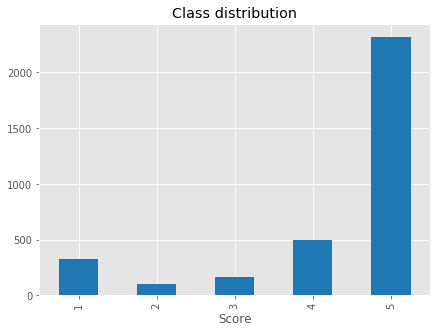

In [9]:
# Visualize class distribution  -- shows that data is hugely imbalanced
print(df.groupby('Score').Review.count())
print('Total %d' % df['Review'].count())
df.groupby('Score').Review.count().plot.bar(figsize=(7,5), title='Class distribution', colormap='tab20')
plt.show()

In [10]:
# Split into training and test set. Given the low number of examples we do not create a validation set. Also,
# keep the class distribution to ensure representation (use stratify parameter)
X_train, X_test, y_train, y_test = train_test_split(df['clean_merge'], df['Score'], stratify=df['Score'], test_size=0.2, random_state=42)
print('Total examples in training is {} distributed per class as: {}'.format(y_train.shape[0], Counter(y_train)))
print('Total examples in test is {} distributed per class as: {}'.format(y_test.shape[0], Counter(y_test)))

Total examples in training is 2729 distributed per class as: Counter({5: 1857, 4: 401, 1: 262, 3: 131, 2: 78})
Total examples in test is 683 distributed per class as: Counter({5: 465, 4: 100, 1: 65, 3: 33, 2: 20})


# Feature extraction

To extract features from the text we will use the common approach of bag-of-words. This takes into account the presence of words but not the order of them. The representation chosen are tf-idf vectors which discern better between relevant words and not relevant words by weighting them by their tf-idf. 

The data exploration showed how ideas or feelings where expressed in several words. To account for this and also to alleviate the fact that order is not taken into account, we could use bigrams and trigrams (apart from unigrams) so that expression such as "not good" are correctly captured. 

The parameter min_df for the tf-idf matrix which indicats the minimum number of documents in which a word needs to appear to consider it for the vocabulary, is set to a low number, such as 2, because the same idea can be expressed with different words such as 'great delivery' 'excellent shipping', and it is likely that not all users coincide in this. Therefore, a high min_df would be very strict for this task and leave features out. 

Lemmatization is applied to reduce the feature space in a sensible way.

# Fixing imbalanced data and feature selection

The main challenge in this classification task is to learn the imbalanced classes. Even though preprocessing helps to point out the relevant features of the text and improve performance, it is the imbalance issue what will determine the performance. The imbalance issue can be approached by either oversampling the minority classes or undersampling the majority class. The intuition for the latter is that it will lead to very few data points and thus, a drop in the performance, at least for the majority class. Therefore, we will try just one mehtod for it. For the former, it can be done by randomly sampling with replacement (ROS) from the data set or by creating artificial new examples using the neighbour data points (SMOTE). To find which approach is the best to alleviate the imbalance we perform cross-validation on the training data.

The cross-validation also compares whether to use trigrams or no, apart from unigrmas and bigrams. 

The model chose is Support Vector Machines for classification. Given that it is a multi-class classification, the model train 5 classifiers, one per class, that classify one class vs. the rest. SVM is a very good model to deal with high-dimensional data and performs good for text classification.

### Metrics

For this siutation with imbalance classes it is better to use the F1 score, precision and recall metrics. In this set up, it is likely that the classifier will try to assign the majority class label to all of the examples. If we only measure the accuracy we will not be able to spot this situation since the majority of the examples will be predicted correctly and accuracy will be high due to this. The F1 score, precision and recall are more expressive and measure more information. Precision measures from the examples predicted per class how many were correct. Recall measures from the number of examples from a class how many were classified correctly. The F1 score is the harmonic mean of both. Nevertheless, depending on the high-level goal of the classifier, i.e. the business case or application it will be used in, a different metric can be used for it.

In [11]:
def apply_cv(k, X, y, pipeline, average_method):
    """
    Apply k-fold stratified cross validation to X and y with the pipeline
    and report metrics averaged according to average_method. 
    Args:
        k: int, number of folds.
        X: DataFrame, the data.
        y: DataFrame, the labels.
        pipeline: pipeline object, the pipeline to apply to the data.
        average_method: str, average method from 'macro', 'micro',
                        'weighted', for more info see
                        sklearn.metrics.precision_recall_fscore_support
    
    """
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accuracy = []
    precision = []
    recall = []
    f_score = []
    for fold, (train, test) in enumerate(kfold.split(X, y)):
        model_fit = pipeline.fit(X.iloc[train], y.iloc[train])
        pred = model_fit.predict(X.iloc[test])
        
        # Metrics for fold k
        print('Fold %s' % str(fold+1))
        acc = accuracy_score(y.iloc[test], pred, normalize=True, sample_weight=None)
        print('Accuracy: %s' % acc)
        p, r, f, _ = precision_recall_fscore_support(y.iloc[test], pred)
        print('Precision: {} \nRecall: {} \nFscore {}'.format(p, r, f))
        
        # Metrics for the final average 
        accuracy.append(acc)
        p, r, f, _ = precision_recall_fscore_support(y.iloc[test], pred, average=average_method)
        precision.append(p)
        recall.append(r)
        f_score.append(f)
        print('\n')
        
    print('%i-fold cv results:' % k)    
    print('Accuracy: %.2f%% (+/- %.2f%%)' % (np.mean(accuracy), np.std(accuracy)))
    print('Precision: %.2f%% (+/- %.2f%%)' % (np.mean(precision), np.std(precision)))
    print('Recall: %.2f%% (+/- %.2f%%)' % (np.mean(recall), np.std(recall)))
    print('F1 score: %.2f%% (+/- %.2f%%)' % (np.mean(f_score), np.std(f_score)))

In [27]:
k = 10
average_method = 'macro'
tfidf_vect_bi = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df=2,
                                   stop_words='english', 
                                   norm='l2', 
                                   sublinear_tf=True)

tfidf_vect_tri = TfidfVectorizer(ngram_range=(1, 3), 
                                   min_df=2,
                                   stop_words='english', 
                                   norm='l2', 
                                   sublinear_tf=True)

# Classifiers
linear_svc = LinearSVC(penalty='l2', dual=False, tol=1e-4)
# Oversampling and undersampling methods
ros = RandomOverSampler(ratio='auto', random_state=42)
smote = SMOTE(ratio='auto', random_state=42)
rus = RandomUnderSampler(ratio='auto', random_state=42)

In [28]:
bi_pipeline = scikit_pipeline([
    ('vect', tfidf_vect_bi),
    ('clf', linear_svc)])

apply_cv(k, X_train, y_train, bi_pipeline, average_method=average_method)

Fold 1
Accuracy: 0.717391304347826
Precision: [0.71428571 0.         0.16666667 0.29411765 0.76623377] 
Recall: [0.55555556 0.         0.07142857 0.12195122 0.9516129 ] 
Fscore [0.625      0.         0.1        0.17241379 0.84892086]


Fold 2
Accuracy: 0.7116788321167883
Precision: [0.65517241 0.         0.25       0.18181818 0.78082192] 
Recall: [0.7037037  0.         0.07692308 0.1        0.91935484] 
Fscore [0.67857143 0.         0.11764706 0.12903226 0.84444444]




/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 3
Accuracy: 0.7509157509157509
Precision: [0.64       0.         0.5        0.38888889 0.8       ] 
Recall: [0.61538462 0.         0.15384615 0.175      0.96774194] 
Fscore [0.62745098 0.         0.23529412 0.24137931 0.87591241]


Fold 4
Accuracy: 0.7216117216117216
Precision: [0.72       0.         0.         0.26086957 0.77927928] 
Recall: [0.69230769 0.         0.         0.15       0.93010753] 
Fscore [0.70588235 0.         0.         0.19047619 0.84803922]




/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 5
Accuracy: 0.7142857142857143
Precision: [0.62962963 0.         0.         0.21052632 0.7699115 ] 
Recall: [0.65384615 0.         0.         0.1        0.93548387] 
Fscore [0.64150943 0.         0.         0.13559322 0.84466019]




/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 6
Accuracy: 0.7655677655677655
Precision: [0.68965517 0.         0.         0.57142857 0.79385965] 
Recall: [0.76923077 0.         0.         0.2        0.97311828] 
Fscore [0.72727273 0.         0.         0.2962963  0.87439614]




/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 7
Accuracy: 0.7435897435897436
Precision: [0.68181818 0.         0.25       0.44444444 0.78165939] 
Recall: [0.57692308 0.         0.07692308 0.2        0.96236559] 
Fscore [0.625      0.         0.11764706 0.27586207 0.8626506 ]




/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 8
Accuracy: 0.7132352941176471
Precision: [0.5862069  0.         0.         0.26666667 0.76211454] 
Recall: [0.65384615 0.         0.         0.1        0.93513514] 
Fscore [0.61818182 0.         0.         0.14545455 0.83980583]




/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 9
Accuracy: 0.7490774907749077
Precision: [0.66666667 0.         0.         0.36842105 0.79820628] 
Recall: [0.69230769 0.         0.         0.175      0.96216216] 
Fscore [0.67924528 0.         0.         0.23728814 0.87254902]


Fold 10
Accuracy: 0.7490774907749077
Precision: [0.75       0.5        0.5        0.27777778 0.7918552 ] 
Recall: [0.80769231 0.14285714 0.07692308 0.125      0.94594595] 
Fscore [0.77777778 0.22222222 0.13333333 0.17241379 0.86206897]


10-fold cv results:
Accuracy: 0.73% (+/- 0.02%)
Precision: 0.40% (+/- 0.07%)
Recall: 0.36% (+/- 0.02%)
F1 score: 0.36% (+/- 0.03%)


In [29]:
tri_pipeline = scikit_pipeline([
    ('vect', tfidf_vect_tri),
    ('clf', linear_svc)])

apply_cv(k, X_train, y_train, tri_pipeline, average_method=average_method)

Fold 1
Accuracy: 0.7246376811594203
Precision: [0.71428571 0.         0.25       0.36842105 0.76623377] 
Recall: [0.55555556 0.         0.07142857 0.17073171 0.9516129 ] 
Fscore [0.625      0.         0.11111111 0.23333333 0.84892086]


Fold 2
Accuracy: 0.7153284671532847
Precision: [0.6875     0.         0.         0.2173913  0.78604651] 
Recall: [0.81481481 0.         0.         0.125      0.90860215] 
Fscore [0.74576271 0.         0.         0.15873016 0.84289277]




/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 3
Accuracy: 0.7545787545787546
Precision: [0.61538462 0.         0.5        0.42105263 0.80717489] 
Recall: [0.61538462 0.         0.15384615 0.2        0.96774194] 
Fscore [0.61538462 0.         0.23529412 0.27118644 0.8801956 ]


Fold 4
Accuracy: 0.7216117216117216
Precision: [0.69230769 0.         0.         0.26086957 0.78280543] 
Recall: [0.69230769 0.         0.         0.15       0.93010753] 
Fscore [0.69230769 0.         0.         0.19047619 0.85012285]




/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 5
Accuracy: 0.7032967032967034
Precision: [0.60714286 0.         0.         0.1875     0.76106195] 
Recall: [0.65384615 0.         0.         0.075      0.92473118] 
Fscore [0.62962963 0.         0.         0.10714286 0.83495146]


Fold 6
Accuracy: 0.7545787545787546
Precision: [0.67857143 0.         0.         0.5        0.78354978] 
Recall: [0.73076923 0.         0.         0.15       0.97311828] 
Fscore [0.7037037  0.         0.         0.23076923 0.86810552]




/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 7
Accuracy: 0.7435897435897436
Precision: [0.69565217 0.         0.25       0.4375     0.77826087] 
Recall: [0.61538462 0.         0.07692308 0.175      0.96236559] 
Fscore [0.65306122 0.         0.11764706 0.25       0.86057692]




/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 8
Accuracy: 0.7205882352941176
Precision: [0.5862069  0.         0.         0.30769231 0.76419214] 
Recall: [0.65384615 0.         0.         0.1        0.94594595] 
Fscore [0.61818182 0.         0.         0.1509434  0.84541063]




/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 9
Accuracy: 0.7453874538745388
Precision: [0.66666667 0.         0.         0.35       0.7972973 ] 
Recall: [0.69230769 0.         0.         0.175      0.95675676] 
Fscore [0.67924528 0.         0.         0.23333333 0.86977887]


Fold 10
Accuracy: 0.7601476014760148
Precision: [0.77777778 0.5        0.5        0.35294118 0.79372197] 
Recall: [0.80769231 0.14285714 0.07692308 0.15       0.95675676] 
Fscore [0.79245283 0.22222222 0.13333333 0.21052632 0.86764706]


10-fold cv results:
Accuracy: 0.73% (+/- 0.02%)
Precision: 0.40% (+/- 0.08%)
Recall: 0.37% (+/- 0.03%)
F1 score: 0.36% (+/- 0.04%)


In [30]:
bi_ros_pipeline = imblearn_pipeline([
    ('vect', tfidf_vect_bi),
    ('sampler', ros),
    ('clf', linear_svc)])

apply_cv(k, X_train, y_train, bi_ros_pipeline, average_method=average_method)

Fold 1
Accuracy: 0.6884057971014492
Precision: [0.71428571 0.         0.11111111 0.27777778 0.7961165 ] 
Recall: [0.55555556 0.         0.07142857 0.24390244 0.88172043] 
Fscore [0.625      0.         0.08695652 0.25974026 0.83673469]


Fold 2
Accuracy: 0.6824817518248175
Precision: [0.62068966 0.         0.25       0.225      0.82631579] 
Recall: [0.66666667 0.         0.23076923 0.225      0.84408602] 
Fscore [0.64285714 0.         0.24       0.225      0.83510638]


Fold 3
Accuracy: 0.7252747252747253
Precision: [0.62962963 0.         0.2        0.375      0.84536082] 
Recall: [0.65384615 0.         0.15384615 0.375      0.88172043] 
Fscore [0.64150943 0.         0.17391304 0.375      0.86315789]


Fold 4
Accuracy: 0.673992673992674
Precision: [0.66666667 0.         0.         0.18918919 0.8071066 ] 
Recall: [0.69230769 0.         0.         0.175      0.85483871] 
Fscore [0.67924528 0.         0.         0.18181818 0.83028721]


Fold 5
Accuracy: 0.6593406593406593
Precision: [0.516

/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 7
Accuracy: 0.6923076923076923
Precision: [0.6        0.         0.22222222 0.3125     0.79802956] 
Recall: [0.57692308 0.         0.15384615 0.25       0.87096774] 
Fscore [0.58823529 0.         0.18181818 0.27777778 0.83290488]


Fold 8
Accuracy: 0.6544117647058824
Precision: [0.53571429 0.         0.         0.25       0.78571429] 
Recall: [0.57692308 0.         0.         0.225      0.83243243] 
Fscore [0.55555556 0.         0.         0.23684211 0.80839895]


Fold 9
Accuracy: 0.7158671586715867
Precision: [0.65384615 0.         0.14285714 0.28571429 0.8115942 ] 
Recall: [0.65384615 0.         0.07692308 0.2        0.90810811] 
Fscore [0.65384615 0.         0.1        0.23529412 0.85714286]


Fold 10
Accuracy: 0.7269372693726938
Precision: [0.70588235 0.5        0.125      0.26666667 0.82741117] 
Recall: [0.92307692 0.14285714 0.07692308 0.2        0.88108108] 
Fscore [0.8        0.22222222 0.0952381  0.22857143 0.85340314]


10-fold cv results:
Accuracy: 0.69% (+/- 0.03%)
Pre

In [31]:
tri_ros_pipeline = imblearn_pipeline([
    ('vect', tfidf_vect_tri),
    ('sampler', ros),
    ('clf', linear_svc)])

apply_cv(k, X_train, y_train, tri_ros_pipeline, average_method=average_method)

Fold 1
Accuracy: 0.7137681159420289
Precision: [0.65217391 0.         0.25       0.36666667 0.80094787] 
Recall: [0.55555556 0.         0.14285714 0.26829268 0.90860215] 
Fscore [0.6        0.         0.18181818 0.30985915 0.85138539]


Fold 2
Accuracy: 0.7043795620437956
Precision: [0.65625    0.         0.25       0.28205128 0.82722513] 
Recall: [0.77777778 0.         0.23076923 0.275      0.84946237] 
Fscore [0.71186441 0.         0.24       0.27848101 0.83819629]




/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 3
Accuracy: 0.717948717948718
Precision: [0.61538462 0.         0.2        0.31428571 0.83084577] 
Recall: [0.61538462 0.         0.15384615 0.275      0.89784946] 
Fscore [0.61538462 0.         0.17391304 0.29333333 0.8630491 ]


Fold 4
Accuracy: 0.6959706959706959
Precision: [0.67857143 0.         0.         0.1875     0.80097087] 
Recall: [0.73076923 0.         0.         0.15       0.88709677] 
Fscore [0.7037037  0.         0.         0.16666667 0.84183673]


Fold 5
Accuracy: 0.6593406593406593
Precision: [0.53333333 0.         0.125      0.26470588 0.77777778] 
Recall: [0.61538462 0.         0.07692308 0.225      0.82795699] 
Fscore [0.57142857 0.         0.0952381  0.24324324 0.80208333]


Fold 6
Accuracy: 0.7142857142857143
Precision: [0.64516129 1.         0.33333333 0.3        0.82051282] 
Recall: [0.76923077 0.125      0.15384615 0.3        0.86021505] 
Fscore [0.70175439 0.22222222 0.21052632 0.3        0.83989501]


Fold 7
Accuracy: 0.6996336996336996
Precision: [0.555

In [32]:
bi_smote_pipeline = imblearn_pipeline([
    ('vect', tfidf_vect_bi),
    ('sampler', smote),
    ('clf', linear_svc)])

apply_cv(k, X_train, y_train, bi_smote_pipeline, average_method=average_method)

Fold 1
Accuracy: 0.6992753623188406
Precision: [0.73684211 0.         0.16666667 0.32352941 0.79807692] 
Recall: [0.51851852 0.         0.14285714 0.26829268 0.89247312] 
Fscore [0.60869565 0.         0.15384615 0.29333333 0.84263959]


Fold 2
Accuracy: 0.6751824817518248
Precision: [0.64516129 0.         0.21428571 0.16216216 0.82105263] 
Recall: [0.74074074 0.         0.23076923 0.15       0.83870968] 
Fscore [0.68965517 0.         0.22222222 0.15584416 0.82978723]


Fold 3
Accuracy: 0.7106227106227107
Precision: [0.61538462 0.         0.15384615 0.38461538 0.83854167] 
Recall: [0.61538462 0.         0.15384615 0.375      0.8655914 ] 
Fscore [0.61538462 0.         0.15384615 0.37974684 0.85185185]


Fold 4
Accuracy: 0.684981684981685
Precision: [0.69230769 0.         0.         0.225      0.81632653] 
Recall: [0.69230769 0.         0.         0.225      0.86021505] 
Fscore [0.69230769 0.         0.         0.225      0.83769634]


Fold 5
Accuracy: 0.6410256410256411
Precision: [0.483

/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 7
Accuracy: 0.6923076923076923
Precision: [0.64       0.         0.22222222 0.3        0.82051282] 
Recall: [0.61538462 0.         0.30769231 0.225      0.86021505] 
Fscore [0.62745098 0.         0.25806452 0.25714286 0.83989501]


Fold 8
Accuracy: 0.6544117647058824
Precision: [0.53571429 0.         0.05555556 0.28125    0.796875  ] 
Recall: [0.57692308 0.         0.07692308 0.225      0.82702703] 
Fscore [0.55555556 0.         0.06451613 0.25       0.81167109]


Fold 9
Accuracy: 0.7084870848708487
Precision: [0.66666667 0.         0.07692308 0.2962963  0.82089552] 
Recall: [0.69230769 0.         0.07692308 0.2        0.89189189] 
Fscore [0.67924528 0.         0.07692308 0.23880597 0.85492228]


Fold 10
Accuracy: 0.7232472324723247
Precision: [0.71875    0.5        0.1        0.27272727 0.83505155] 
Recall: [0.88461538 0.14285714 0.07692308 0.225      0.87567568] 
Fscore [0.79310345 0.22222222 0.08695652 0.24657534 0.85488127]


10-fold cv results:
Accuracy: 0.69% (+/- 0.02%)
Pre

In [33]:
tri_smote_pipeline = imblearn_pipeline([
    ('vect', tfidf_vect_tri),
    ('sampler', smote),
    ('clf', linear_svc)])

apply_cv(k, X_train, y_train, tri_smote_pipeline, average_method=average_method)

Fold 1
Accuracy: 0.6992753623188406
Precision: [0.7        0.         0.16666667 0.33333333 0.79807692] 
Recall: [0.51851852 0.         0.14285714 0.26829268 0.89247312] 
Fscore [0.59574468 0.         0.15384615 0.2972973  0.84263959]


Fold 2
Accuracy: 0.6970802919708029
Precision: [0.67741935 0.         0.26666667 0.25       0.8342246 ] 
Recall: [0.77777778 0.         0.30769231 0.25       0.83870968] 
Fscore [0.72413793 0.         0.28571429 0.25       0.83646113]


Fold 3
Accuracy: 0.7106227106227107
Precision: [0.61538462 0.         0.15384615 0.34285714 0.83248731] 
Recall: [0.61538462 0.         0.15384615 0.3        0.88172043] 
Fscore [0.61538462 0.         0.15384615 0.32       0.85639687]


Fold 4
Accuracy: 0.6923076923076923
Precision: [0.7037037  0.         0.         0.18181818 0.8       ] 
Recall: [0.73076923 0.         0.         0.15       0.88172043] 
Fscore [0.71698113 0.         0.         0.16438356 0.83887468]


Fold 5
Accuracy: 0.6483516483516484
Precision: [0.51

/Users/Sofia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 7
Accuracy: 0.706959706959707
Precision: [0.64       0.         0.23529412 0.33333333 0.82      ] 
Recall: [0.61538462 0.         0.30769231 0.225      0.88172043] 
Fscore [0.62745098 0.         0.26666667 0.26865672 0.84974093]


Fold 8
Accuracy: 0.6470588235294118
Precision: [0.55555556 0.         0.         0.24324324 0.79166667] 
Recall: [0.57692308 0.         0.         0.225      0.82162162] 
Fscore [0.56603774 0.         0.         0.23376623 0.80636605]


Fold 9
Accuracy: 0.7121771217712177
Precision: [0.65384615 0.         0.07142857 0.34782609 0.81463415] 
Recall: [0.65384615 0.         0.07692308 0.2        0.9027027 ] 
Fscore [0.65384615 0.         0.07407407 0.25396825 0.85641026]


Fold 10
Accuracy: 0.7416974169741697
Precision: [0.67647059 0.5        0.16666667 0.31034483 0.835     ] 
Recall: [0.88461538 0.14285714 0.07692308 0.225      0.9027027 ] 
Fscore [0.76666667 0.22222222 0.10526316 0.26086957 0.86753247]


10-fold cv results:
Accuracy: 0.70% (+/- 0.03%)
Prec

In [34]:
bi_rus_pipeline = imblearn_pipeline([
    ('vect', tfidf_vect_bi),
    ('sampler', rus),
    ('clf', linear_svc)])

apply_cv(k, X_train, y_train, bi_rus_pipeline, average_method=average_method)

Fold 1
Accuracy: 0.4782608695652174
Precision: [0.69565217 0.08333333 0.05882353 0.27272727 0.8490566 ] 
Recall: [0.59259259 0.375      0.14285714 0.51219512 0.48387097] 
Fscore [0.64       0.13636364 0.08333333 0.3559322  0.61643836]


Fold 2
Accuracy: 0.40145985401459855
Precision: [0.54166667 0.05714286 0.08333333 0.17171717 0.82608696] 
Recall: [0.48148148 0.25       0.15384615 0.425      0.40860215] 
Fscore [0.50980392 0.09302326 0.10810811 0.24460432 0.54676259]


Fold 3
Accuracy: 0.4065934065934066
Precision: [0.53846154 0.11764706 0.15151515 0.1588785  0.81111111] 
Recall: [0.53846154 0.25       0.38461538 0.425      0.39247312] 
Fscore [0.53846154 0.16       0.2173913  0.23129252 0.52898551]


Fold 4
Accuracy: 0.42124542124542125
Precision: [0.7        0.05882353 0.         0.15789474 0.82075472] 
Recall: [0.53846154 0.25       0.         0.3        0.46774194] 
Fscore [0.60869565 0.0952381  0.         0.20689655 0.59589041]


Fold 5
Accuracy: 0.4175824175824176
Precision: [0.

In [35]:
tri_rus_pipeline = imblearn_pipeline([
    ('vect', tfidf_vect_tri),
    ('sampler', rus),
    ('clf', linear_svc)])

apply_cv(k, X_train, y_train, tri_rus_pipeline, average_method=average_method)

Fold 1
Accuracy: 0.47101449275362317
Precision: [0.63636364 0.1        0.06060606 0.25641026 0.87378641] 
Recall: [0.51851852 0.5        0.14285714 0.48780488 0.48387097] 
Fscore [0.57142857 0.16666667 0.08510638 0.33613445 0.62283737]


Fold 2
Accuracy: 0.42700729927007297
Precision: [0.48148148 0.06060606 0.12       0.19354839 0.84375   ] 
Recall: [0.48148148 0.25       0.23076923 0.45       0.43548387] 
Fscore [0.48148148 0.09756098 0.15789474 0.27067669 0.57446809]


Fold 3
Accuracy: 0.40293040293040294
Precision: [0.53846154 0.11111111 0.13513514 0.15238095 0.83908046] 
Recall: [0.53846154 0.25       0.38461538 0.4        0.39247312] 
Fscore [0.53846154 0.15384615 0.2        0.22068966 0.53479853]


Fold 4
Accuracy: 0.42124542124542125
Precision: [0.65       0.05714286 0.         0.17567568 0.82857143] 
Recall: [0.5        0.25       0.         0.325      0.46774194] 
Fscore [0.56521739 0.09302326 0.         0.22807018 0.59793814]


Fold 5
Accuracy: 0.40293040293040294
Precision: 

### Cross Validation Results
The cross validation shows that:
* From the baseline (without over/under sampling), using trigrams already performs slightly better than not using them since for minority classes it manages to predict some.
* Oversampling yields better results than undersampling. This was expected since undersampling would make the data set even smaller and the minority classes will still be very small. Undersampling the majority just makes it harder to learn the majority class.
* For the two oversampling methods: there seems to be no significant difference between them. In general, with oversampling, the results for the majority class drop a bit, because the predictions of the model are more generalized and and distributed and not that focused on that class.
* Using trigrams did not boosted peroformance but it performed slightly better, although not significantly, for the classifier without sampling and for the precision of the sampling methods.

The results from the cross-validation show that oversampling helps, although it is hard to determine which method. We pick trigrams with SMOTE since its standard deviation is a bit more stable.

# Training the model

Now we train the SVM with unigrams, bigrams and trigrams for the tf-idf. We can do the fine tuning of the parameter C with random search since it is just one parameter. The baseline is a classifier that predicts according to the class distribution.

In [60]:
def train(X_train, y_train, X_test, y_test, classifier):
    
    fitted_model = classifier.fit(X_train, y_train)
    y_pred = fitted_model.predict(X_test)

    print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5']))
    p, r, f, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print('Average Precision: {} \nAverage Recall: {} \nAverage Fscore {}'.format(p, r, f)) 
    
    print('\nConfusion matrix:')
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
    plt.figure(figsize = (6,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
    
    return fitted_model, y_pred

In [48]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), 
                                   min_df=2,
                                   stop_words='english', 
                                   norm='l2', 
                                   sublinear_tf=True)
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
print('Number of features: %d\n' % X_train_vec.shape[1])
X_test_vec = tfidf_vectorizer.transform(X_test)  # use same vectorizer for the test data
classifier = LinearSVC(penalty='l2', dual=False, tol=1e-4, C=0.5) 
baseline = DummyClassifier(strategy="stratified")

smote = SMOTE(ratio='auto', random_state=42)
X_resampled, y_resampled = smote.fit_sample(X_train_vec, y_train)

Number of features: 9638



             precision    recall  f1-score   support

          1       0.13      0.28      0.18        65
          2       0.03      0.20      0.05        20
          3       0.07      0.27      0.11        33
          4       0.12      0.17      0.14       100
          5       0.67      0.20      0.31       465

avg / total       0.49      0.20      0.25       683

Average Precision: 0.20430206867350797 
Average Recall: 0.22349996240318823 
Average Fscore 0.15725391716253384

Confusion matrix:


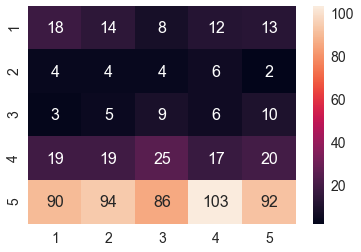

In [61]:
fitted_baseline, y_pred_baseline = train(X_resampled, y_resampled, X_test_vec, y_test, baseline)

             precision    recall  f1-score   support

          1       0.62      0.74      0.67        65
          2       0.08      0.05      0.06        20
          3       0.26      0.27      0.27        33
          4       0.36      0.29      0.32       100
          5       0.84      0.86      0.85       465

avg / total       0.70      0.72      0.71       683

Average Precision: 0.43249054130586667 
Average Recall: 0.4431409880442139 
Average Fscore 0.43510509357903226

Confusion matrix:


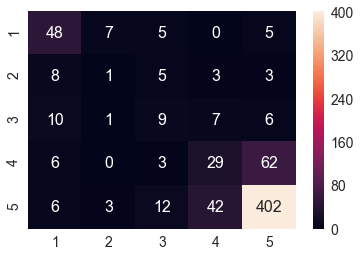

In [62]:
fitted_model, y_pred_model = train(X_resampled, y_resampled, X_test_vec, y_test, classifier)

The trained model performs better on average on the test set than the baseline and than the results from th ecross-validation. It is able to predict one of the imbalanced class but it can be seen that the rest is confused with class 1, so at least it is identifying the negative aspect. For the rest of the classes it performs according to their distribution, as expected.

### Exploring the predictions

In [56]:
# print misclassified examples
indices = np.argwhere(y_pred_model != y_test)
indices = [e[0] for e in indices]
predictions = pd.DataFrame(data=X_test.iloc[indices])
predictions['Score'] = y_test.iloc[indices].values
predictions['Prediction'] = y_pred_model[indices]
predictions.head(194)  # visualize the 194 misclassified examples

,clean_merge,Score,Prediction
2449,amazing service amazing service,4,5
1906,amazing I always shop from seriously They seem to have everything it be simply brilliant :d,4,5
58,good service amazon have always offer fast and good service luckily I have never have to deal with unpleasant situation,4,5
1267,a little angry seller send me wrong color and size he will not replace,2,4
910,false delivery I have pay an extra delivery service to get the mattress before 12:00 a.m the delivery do not take place and there be no way to get information on the status via the tracking number both the amazon website and the delivery service report that the delivery be on go the marketing of amazon in the delivery create issue,1,5
1178,They do not allow me to submit a bad review for bad item sell by amazon They do not allow me to submit a bad review for bad item sell by amazon,1,2
1064,great price amazon prime be wonderful but first off I love amazon have save me on gift tool supply everything after have be save by amazon so many time I begin to notice that know what you want before show up be a big help in fact amazon be not really a place to browse or research the but in the title be for that know what you want the more exact the good and life be beautiful in amazon land,4,5
2177,good service recently I have purchase many thing from amazon and they have all be rec'd really quickly and be exactly the quality product I be look for,5,4
2238,gift voucher give for present be only to be use .com I have a $ gift voucher give to me as a present and be horrify to find I could not transfer the value to the uk site to use it in the .com site involve more money than the good in shipping sad to say vouch stay on the account motto of the story be unless you want amazon to benefit from your money or your american live in america do not give their voucher Their customer service people do not answer question so I presume they do not read them,2,1
1512,only when need I only buy from amazon if they be the only with the product for the good price if another site be a bit high I will go with them because you can actually get more product information that way also amazon will not intervene if there be a quality issue the other thing I do not like about amazon be that allow foreign base seller to use their site make american believe they be usa base I have find that many vendor be just from ebay and base in china I give them star because when you do buy item arrive pretty quick I be not sure how they will stay in business base on some of the silly free shipping I purchase once $ worth of sticker and receive the next day and balance of order day later They have to have lose money and I give them the star base on their amazon prime tv service They offer show that other do not,4,1


Most of the misclassification are between similar classes (scores 4 and 5, or scores 1 and 2). This indicates that the features are discriminant enough to separate between classes 1 and 5 but not between similar classes, which is expected due to the imbalance.

In [57]:
# Plot the top/least n-grams for each Score according to the model
N = 5
for score in range(5):
    indices = np.argsort(fitted_model.coef_[score])
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
    # separate unigrams and bigrams
    top_unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    top_bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    top_trigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 3][:N]
    worst_unigrams = [v for v in feature_names if len(v.split(' ')) == 1][:N]
    worst_bigrams = [v for v in feature_names if len(v.split(' ')) == 2][:N]
    worst_trigrams = [v for v in feature_names if len(v.split(' ')) == 3][:N]
    print("Score {}:".format(score+1))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(top_unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(top_bigrams)))
    print("  . Top trigrams:\n       . {}".format('\n       . '.join(top_trigrams)))
    print("Score {}:".format(score+1))
    print("  . Last unigrams:\n       . {}".format('\n       . '.join(worst_unigrams)))
    print("  . Last bigrams:\n       . {}".format('\n       . '.join(worst_bigrams)))
    print("  . Last trigrams:\n       . {}".format('\n       . '.join(worst_trigrams)))
    print('-' * 60)


Score 1:
  . Top unigrams:
       . rubbish
       . refuse
       . steal
       . help
       . poor
  . Top bigrams:
       . delivery late
       . poor company
       . hate amazon
       . review amazon
       . lose transit
  . Top trigrams:
       . good price good
       . amazon customer service
       . prime member order
       . book site easy
       . bad customer service
Score 1:
  . Last unigrams:
       . good
       . great
       . love
       . age
       . amazing
  . Last bigrams:
       . amazon help
       . dispute charge
       . customer care
       . order order
       . love amazon
  . Last trigrams:
       . use amazon gift
       . cancel order order
       . contact amazon help
       . item seller amazon
       . amazon customer year
------------------------------------------------------------
Score 2:
  . Top unigrams:
       . reseller
       . speak
       . hardcover
       . poor
       . directly
  . Top bigrams:
       . nice product
       . exp

In [63]:
df[df['clean_merge'].str.contains('bad experience amazon')]

,Title,Review,Score,clean_review,clean_title,clean_merge
1622,Great...,"My experience with Amazon hasn't been 100% which may make individuals think why 5 stars? The reason is that Amazon stands behind their customers if anything occurs. For example, if my order is lost then Amazon takes responsibility and doesn't say ""It is not my problem, it is yours."" If I ever had any bad experiences, Amazon would try their best rectifying the problem and that is what I need. I need to know that I can trust who I am buying from.",5,My experience with amazon have not be which may make individual think why star the reason be that amazon stand behind their customer if anything occur for example if my order be lose then amazon take responsibility and do not say It be not my problem it be yours if I ever have any bad experience amazon would try their good rectify the problem and that be what I need I need to know that I can trust who I be buy from,great,great My experience with amazon have not be which may make individual think why star the reason be that amazon stand behind their customer if anything occur for example if my order be lose then amazon take responsibility and do not say It be not my problem it be yours if I ever have any bad experience amazon would try their good rectify the problem and that be what I need I need to know that I can trust who I be buy from
